# Learning outcomes
Two image segmentation techniques:
1. Clustering-based
    * k-means clustering
2. Region-based
    * watershed segmentation

# Setup

In [1]:
import sys
assert sys.version_info >= (3, 8)

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

if not cv.useOptimized():
    cv.setUseOptimized(True)

cv.useOptimized()

True

# Demo on simple 2D dataset

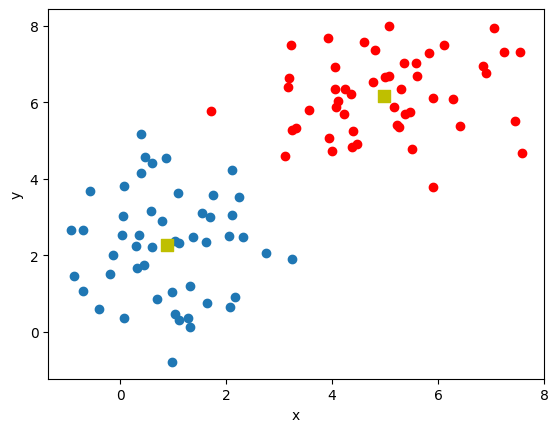

In [7]:
rng = np.random.default_rng(100)
mean1 = (1, 2)
cov1 = [[1, 0], [0, 2]]
X1, Y1 = rng.multivariate_normal(mean1, cov1, size=50).T  # without transpose, (50, 2)
dat1 = np.concatenate((X1[:, None], Y1[:, None]), axis=1)

rng = np.random.default_rng(0)
mean2 = (5, 6)
cov2 = [[2, 0], [0, 1]]
X2, Y2 = rng.multivariate_normal(mean2, cov2, size=50).T
dat2 = np.concatenate((X2[:, None], Y2[:, None]), axis=1)

# vertical stack and cast
Z = np.vstack((dat1, dat2))
Z = np.float32(Z)

# define criteria and apply kmeans
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret, label, center = cv.kmeans(Z, 2, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

# label the data in cluster
A = Z[label.ravel() == 0]
B = Z[label.ravel() == 1]

# Plot the data
plt.scatter(A[:, 0], A[:, 1])
plt.scatter(B[:, 0], B[:, 1], c="r")
plt.scatter(center[:, 0], center[:, 1], s=80, c="y", marker="s")
plt.xlabel('x'), plt.ylabel('y')
plt.show()

## Demo on images

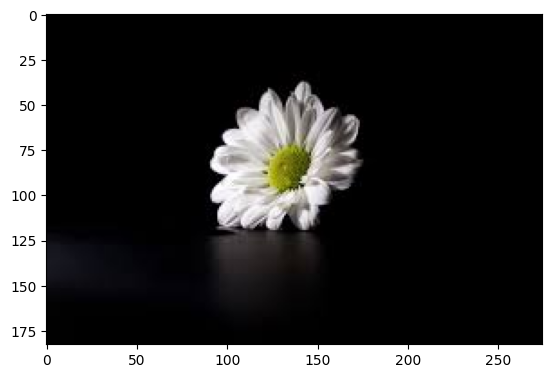

In [8]:
img = cv.imread("images/flower.jfif")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.figure()
plt.imshow(img_rgb)
plt.show()

In [9]:
# Reshape the image to 2D matrix
img_reshape = img_rgb.reshape((-1, 3))

# convert uint8 to float
img_reshape = np.float32(img_reshape)

# define criteria, number of clusters and apply k-means clustering
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
attempts = 10
ret, label, center = cv.kmeans(img_reshape, K, None, criteria, attempts, 
                              cv.KMEANS_PP_CENTERS)

# convert the center back to uint8
center = np.uint8(center)

# broadcast the center to the same size as the image
res = center[label.flatten()]
result_image = res.reshape((img_rgb.shape))

In [15]:
label

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

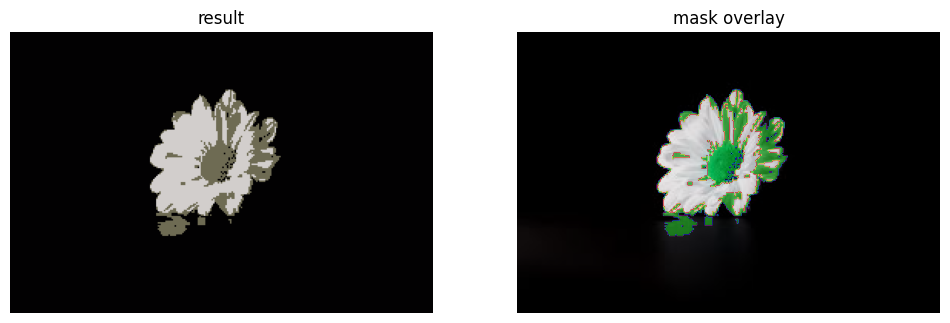

In [12]:
result_image_gray = cv.cvtColor(result_image, cv.COLOR_RGB2GRAY)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1), plt.imshow(result_image), plt.title("result"), plt.axis("off")
plt.subplot(1, 2, 2), plt.imshow(img), plt.title("mask overlay"), plt.axis("off")
plt.imshow(result_image_gray, cmap=plt.cm.nipy_spectral, alpha=.5)
plt.show()

In [16]:
# 2 helper functions to visualize the cluster distribution

def centroid_histogram(clust_labels):
    numLabels = len(np.unique(clust_labels))
    hist = np.bincount(clust_labels.flatten(), minlength=numLabels)

    # normalize the histogram
    hist = hist.astype(np.float32)
    hist /= hist.sum()
    return hist

def plot_colors(hist, centroids):
    # initialize stacked bar chart
    bar = np.zeros((50, 300, 3), dtype=np.uint8)
    startX = 0

    # Loop over the percentage of each cluster and the color of each cluster
    for percent, color in zip(hist, centroids):
        endX = startX + percent * 300
        cv.rectangle(bar, (int(startX), 0), (int(endX), 50), 
                    color.astype("uint8").tolist(), -1)
        startX = endX

    return bar

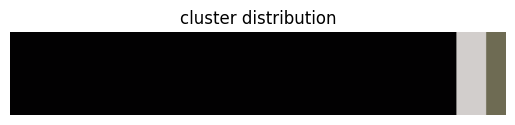

In [17]:
hist = centroid_histogram(label)
bar = plot_colors(hist, center)
plt.figure(), plt.imshow(bar), plt.title("cluster distribution"), plt.axis("off")
plt.show()

# Watershed segmentation


In [2]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from utils import display_image

In [3]:
img = cv.imread("images/traffic_sign.jfif")
blur = cv.GaussianBlur(img, (5, 5), 0)
blur = cv.pyrMeanShiftFiltering(blur, 15, 20, maxLevel=2)

gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)
display_image("gray", gray)

In [4]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
loc_grad = cv.morphologyEx(gray, cv.MORPH_GRADIENT, kernel, iterations=2)

display_image("local gradient", loc_grad)

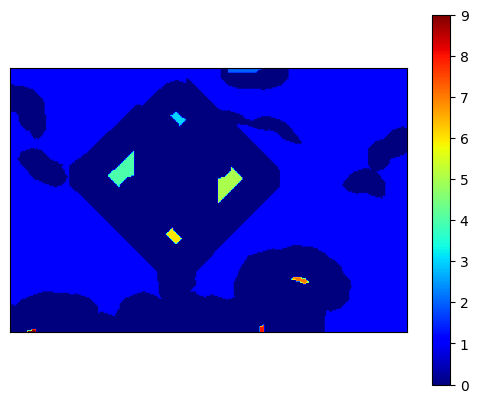

In [5]:
markers = loc_grad < 80
s = np.ones((3, 3), dtype=int)
markers = ndi.label(markers, structure=s)[0]

plt.imshow(markers, cmap=plt.cm.jet)
plt.colorbar()
plt.xticks([]), plt.yticks([])
plt.show()

In [6]:
edge = cv.Canny(gray, 250, 500)
labels = watershed(edge, markers)
np.unique(labels, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([40736,   279,  1234,  2325,  2295,  1270,  1066,   736,   384],
       dtype=int64))

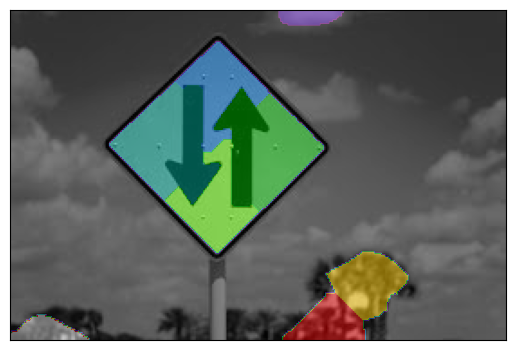

In [7]:
gray_ori = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(gray_ori, cmap=plt.cm.gray)
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=0.5)
plt.xticks([]), plt.yticks([])
plt.show()

### How to retrieve just the traffic sign?

In [9]:
label, counts = np.unique(labels, return_counts=True)

label_bg = label[np.argmax(counts)]

mask = 255 * np.ones(labels.shape, dtype=np.uint8)
mask[labels == label_bg] = 0

# find contour
contours, _ = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contour_max = max(contours, key=cv.contourArea)

img_copy = img.copy()
cv.drawContours(img_copy, [contour_max], -1, (0, 0, 255), 3, cv.LINE_AA)
display_image("segmentation result", img_copy)